This is the very last stage of our pronunciation prediction. We will evaluate the models’ classification performance at this stage. Since we can’t say that our answer dataset is accurate, it’s wise to follow each process and make it as an opportunity to learn about the overall evaluation process. The evaluation process can be divided into a two main steps.

1. **Predict on test dataset:** We first load our fine-tuned models and make a prediction on our test dataset. Recall that we saved our test dataset in `test.pkl` file.
2. **Evaluation and graph visualization:** Compare the prediction with the original labels, we evaluate the model performance. And we visualize their prediction results as heatmap. To check various evaluation metrics results, we will use `classification_report` from scikit learn.

# 1. Import packages

First, import packages.

In [ ]:
import pandas as pd
import librosa
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 2. Predict on test dataset

To predict on the test dataset, first make sure your GPU is available.

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Then, we load our test dataset, `test.pkl` and store it into `answer_df` variable. We take only 100 test samples to reduce execution time. (Since we need to run a total of four models, the overall execution time is very long) If you want to test on whole dataset, you can simply skip the last code from below.


In [ ]:
# load test dataset
answer_df = pd.read_pickle('your_own_path/test.pkl')
# take only 100 test samples to reduce execution time
# if you want to test on whole dataset, just skip this code
answer_df = answer_df[:100]

And we preprocess our test data as we already did in previous stages. Since all of our four models use the same feature extractor, we used the model’s feature extractor as a representative.

In [ ]:
# Since all four models used the same feature extractor, we used the accuracy model's feature extractor as a representative
feature_extractor = AutoFeatureExtractor.from_pretrained("JunBro/pronunciation_scoring_model_accuracy")
tqdm.pandas()
answer_df['sample'] = answer_df['file_path'].progress_apply(lambda x : librosa.load(x)[0])
answer_df['input'] = answer_df['sample'].progress_apply(lambda x : feature_extractor(x, sampling_rate=16000, return_tensors="pt"))

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

100%|██████████| 100/100 [00:02<00:00, 38.20it/s]


Load each model.

In [ ]:
# load each model for each pronunciation metrics
model1 = AutoModelForAudioClassification.from_pretrained("JunBro/pronunciation_scoring_model_accuracy")
model2 = AutoModelForAudioClassification.from_pretrained("JunBro/pronunciation_scoring_model_completeness")
model3 = AutoModelForAudioClassification.from_pretrained("JunBro/pronunciation_scoring_model_fluency")
model4 = AutoModelForAudioClassification.from_pretrained("JunBro/pronunciation_scoring_model_prosodic")

config.json:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

And we define a simple function `predict` that returns the predicted class of an input. As we did in the earlier stage, this function pass the input to the model and take the logits. And it return the class with the highest probability, using the `torch.argmax()` method.

In [ ]:
# Define prediction function
def predict(model, inputs):
  with torch.no_grad():
    logits = model(**inputs).logits
  predicted_class_ids = torch.argmax(logits).item()
  return predicted_class_ids

Finally, we initialize `predict_df` data frame that will contain predicted values and use `predict` function to predict each speech’s pronunciation score.

In [ ]:
# initialize predict_df dataframe that will contain predicted values
predict_df = pd.DataFrame(columns = ['input', 'accuracy', 'completeness', 'fluency', 'prosodic'])
predict_df['input'] = answer_df['input']

In [ ]:
# prediction
predict_df['accuracy'] = predict_df['input'].progress_apply(lambda x: predict(model1, x))
predict_df['completeness'] = predict_df['input'].progress_apply(lambda x: predict(model2, x))
predict_df['fluency'] = predict_df['input'].progress_apply(lambda x: predict(model3, x))
predict_df['prosodic'] = predict_df['input'].progress_apply(lambda x: predict(model4, x))

100%|██████████| 100/100 [07:31<00:00,  4.51s/it]


# 3. Evaluation and graph visualization

In this step, we evaluate classification performance of our models. We first initialize `target_names` as a list of classes (Bad, Normal, Good), and `y_test` and `y_pred` are assigned the actual and predicted values for the ‘accuracy’ score. Next, we generate the confusion matrix. The confusion matrix is computed using scikit-learn’s `confusion_matrix()` method, comparing the actual(`y_test`) and predicted(`y_pred`) values. Then we visualize the confusion matrix. We create a heatmap for the confusion matrix, and the graph is displayed with class labels along the axes. Finally, we print the classification report. It includes precision, recall, f1-score and support for each class. If you execute the code, you will have a result looks similar to the image below.

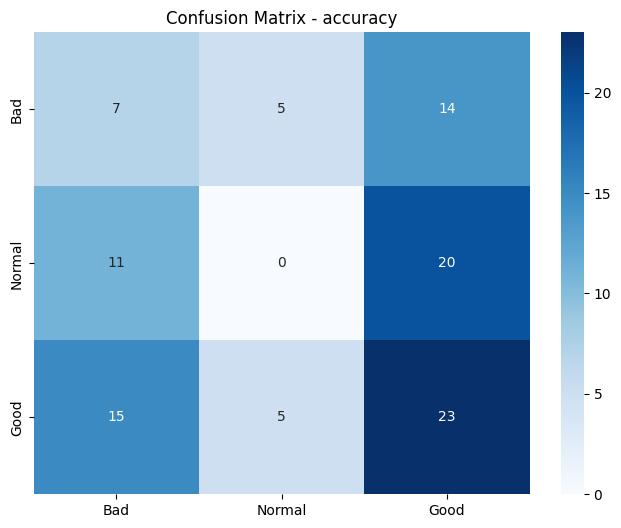

Classification Report:
               precision    recall  f1-score   support

         Bad       0.21      0.27      0.24        26
      Normal       0.00      0.00      0.00        31
        Good       0.40      0.53      0.46        43

    accuracy                           0.30       100
   macro avg       0.21      0.27      0.23       100
weighted avg       0.23      0.30      0.26       100



In [ ]:
# initialize target_names, y_test, y_pred
target_names = ['Bad', 'Normal', 'Good']
y_test = answer_df['accuracy']
y_pred = predict_df['accuracy']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - accuracy")
plt.show()

# Print classification report
class_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", class_report)

And we also evaluate remaining models.

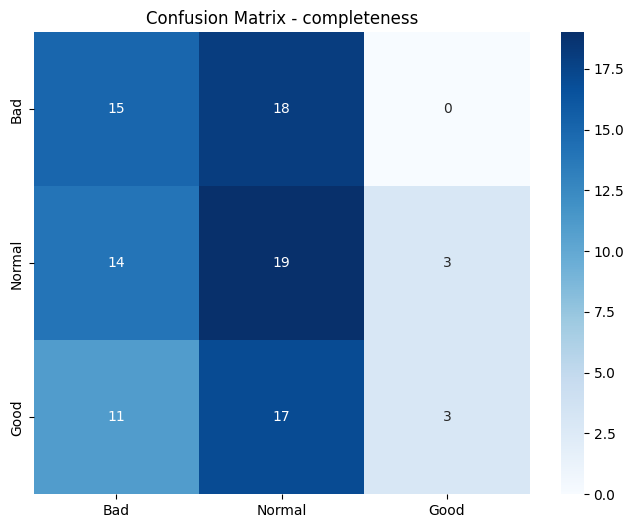

Classification Report:
               precision    recall  f1-score   support

         Bad       0.38      0.45      0.41        33
      Normal       0.35      0.53      0.42        36
        Good       0.50      0.10      0.16        31

    accuracy                           0.37       100
   macro avg       0.41      0.36      0.33       100
weighted avg       0.41      0.37      0.34       100



In [ ]:
# initialize y_test, y_pred
y_test = answer_df['completeness']
y_pred = predict_df['completeness']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - completeness")
plt.show()

# Print classification report
class_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", class_report)

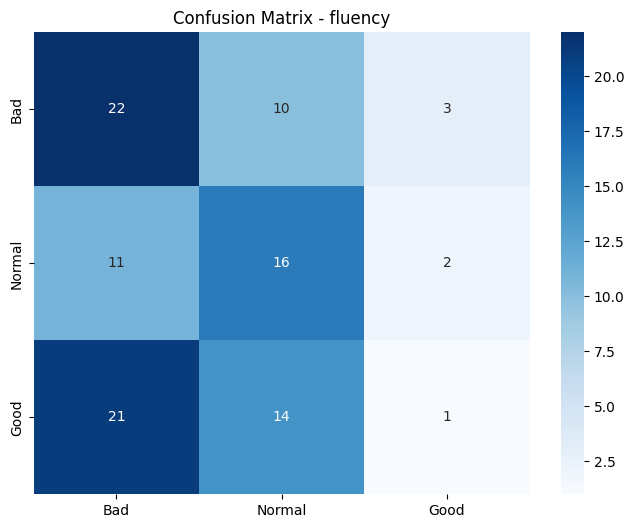

Classification Report:
               precision    recall  f1-score   support

         Bad       0.41      0.63      0.49        35
      Normal       0.40      0.55      0.46        29
        Good       0.17      0.03      0.05        36

    accuracy                           0.39       100
   macro avg       0.32      0.40      0.34       100
weighted avg       0.32      0.39      0.32       100



In [ ]:
# initialize y_test, y_pred
y_test = answer_df['fluency']
y_pred = predict_df['fluency']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - fluency")
plt.show()

# Print classification report
class_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", class_report)

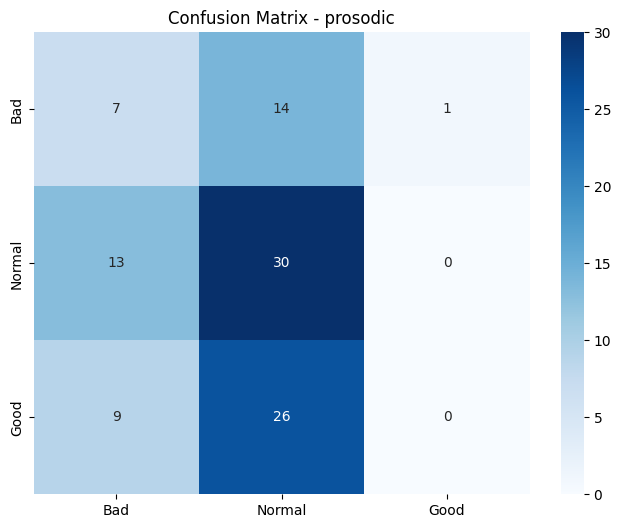

Classification Report:
               precision    recall  f1-score   support

         Bad       0.24      0.32      0.27        22
      Normal       0.43      0.70      0.53        43
        Good       0.00      0.00      0.00        35

    accuracy                           0.37       100
   macro avg       0.22      0.34      0.27       100
weighted avg       0.24      0.37      0.29       100



In [ ]:
# initialize y_test, y_pred
y_test = answer_df['prosodic']
y_pred = predict_df['prosodic']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - prosodic")
plt.show()

# Print classification report
class_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", class_report)